In [2]:
import torch
import torch.nn.functional as F # torch.nn.functional is a module that contains all the functions in the torch.nn library
import matplotlib.pyplot as plt
import random

In [3]:
words = open("names.txt", "r").read().splitlines()
print(len(words))
print(words[:10])

chars = sorted(set(''.join(words)))
print(chars)

32033
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']
['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [4]:
char2idx = {c: i+1 for i, c in enumerate(chars)}
char2idx['.'] = 0
print(char2idx)

idx2char = {i: c for c, i in char2idx.items()}
print(idx2char)

vocab_size = len(idx2char)
print(vocab_size)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
block_size = 3

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = char2idx[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

random.seed(42)
shuffled_words = words.copy()
random.shuffle(shuffled_words)
n1 = int(0.8 * len(shuffled_words))
n2 = int(0.9 * len(shuffled_words))

Xtr, Ytr = build_dataset(words[:n1]) # 80% training
print("Train Length: ", len(Xtr))
Xdev, Ydev = build_dataset(words[n1:n2]) # 10% development
print("Dev   Length: ", len(Xdev))
Xte, Yte = build_dataset(words[n2:]) # 10% test
print("Test  Length: ", len(Xte))

Train Length:  182778
Dev   Length:  22633
Test  Length:  22735


In [6]:
# -----------------------------------------------------------------------------------------------
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------

In [8]:
torch.manual_seed(42);

In [66]:
n_embd = 10
n_hidden = 200

C = torch.randn((vocab_size, n_embd))

layers = [
    Linear(block_size * n_embd, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, vocab_size)
]

with torch.no_grad():
  layers[-1].weight *= 0.1 # letzten Layer weniger Confident machen, quasi Kaiming init

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.numel() for p in parameters))
for p in parameters:
  p.requires_grad = True

12097


Epoche: 0 LR 0.1 Loss: 3.3229243755340576
Epoche: 10000 LR 0.1 Loss: 2.130737781524658
Epoche: 20000 LR 0.1 Loss: 1.9563651084899902
Epoche: 30000 LR 0.1 Loss: 2.498018980026245
Epoche: 40000 LR 0.1 Loss: 2.042588710784912
Epoche: 50000 LR 0.1 Loss: 1.7008590698242188
Epoche: 60000 LR 0.1 Loss: 1.9200161695480347
Epoche: 70000 LR 0.1 Loss: 2.3804004192352295
Epoche: 80000 LR 0.1 Loss: 2.0637707710266113
Epoche: 90000 LR 0.1 Loss: 2.1497390270233154
Epoche: 100000 LR 0.1 Loss: 2.033413887023926
Epoche: 110000 LR 0.1 Loss: 1.8866026401519775
Epoche: 120000 LR 0.1 Loss: 2.1536765098571777
Epoche: 130000 LR 0.1 Loss: 2.0250437259674072
Epoche: 140000 LR 0.1 Loss: 2.195512056350708
Epoche: 150000 LR 0.1 Loss: 2.2363924980163574
Epoche: 160000 LR 0.01 Loss: 1.6972484588623047
Epoche: 170000 LR 0.01 Loss: 1.7971456050872803
Epoche: 180000 LR 0.01 Loss: 2.0951108932495117
Epoche: 190000 LR 0.01 Loss: 1.8731547594070435


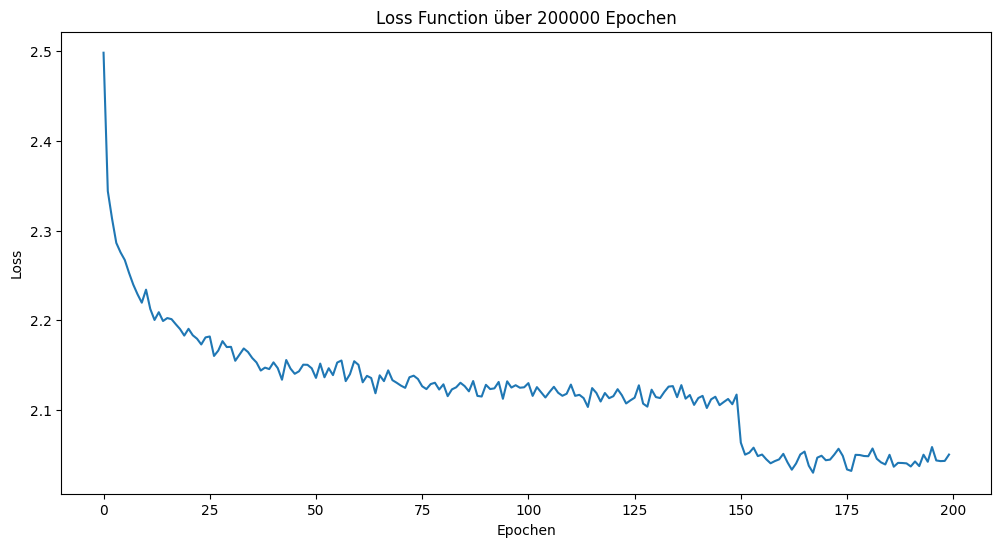

train Loss: 2.0120110511779785
dev Loss: 2.3214542865753174
test Loss: 2.3530666828155518


In [67]:
LR = 0.1
EPOCHEN = 200000
BATCH_SIZE = 32
lossi = []

for i in range(EPOCHEN):

    # Zufällige 32er Mini Batches jede Epoche -> "Stochastic Gradient Descent"
    ix = torch.randint(0, Xtr.shape[0], (BATCH_SIZE,))
    X, Y = Xtr[ix], Ytr[ix]

    # forward Pass
    emb = C[X] # Embedding Chars into Embed-Vectors
    x = emb.view(emb.shape[0], -1) # Concatenate Embed-Vectors
    for layer in layers:
        x = layer(x) # x wird jedesmal überschrieben und geht so durch alle Layer.
    loss = F.cross_entropy(x, Y)
    lossi.append(loss.item())

    if i % 10000 == 0:
        print("Epoche:", i, "LR", LR ,"Loss:", loss.item())

    # backward Pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update Parameters
    if i > 150000:
        LR = 0.01
    for p in parameters:
        p.data += -LR * p.grad
        
# Loss Function plotten:
# Avg über den Loss machen, damit plot nicer
lossi = torch.tensor(lossi).view(-1, 1000).mean(1)
    
plt.figure(figsize=(8, 4))
plt.plot(lossi)
plt.title(f"Loss Function über {EPOCHEN} Epochen")
plt.xlabel("Epochen")
plt.ylabel("Loss")
plt.show();

# Für BatchNorm Training deaktiveren, wegen Mean und Variance
for layer in layers:
    layer.training = False

#Letzter Forward Pass durch alle Daten, für Loss test
@torch.no_grad() # Kein Gradienten-Tracking, für Performance
def split_loss(split):
    x,y = {
        "train": (Xtr, Ytr),
        "dev": (Xdev, Ydev),
        "test": (Xte, Yte)
    }[split]

    emb = C[x]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    print(f"{split} Loss:", loss.item())

split_loss("train")
split_loss("dev")
split_loss("test")

In [79]:
# Generieren von Namen:
for _ in range(10):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])] # ([1, 3, 10])
        x = emb.view(emb.shape[0], -1) # ([1, 30]) der Prozess wird auch flattening genannt
        for layer in layers:
            x = layer(x)
        logits = x        
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(idx2char[i] for i in out))

ezie.
ayonna.
graceliam.
sedawriana.
caesyn.
aamiya.
ash.
niko.
bechaerynn.
stasha.


Nun bauen wir noch eine Komponente für die Embedding Schicht und das Flattening:

In [104]:
# -----------------------------------------------------------------------------------------------
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Embedding:

    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self):
        return [self.weight]

# -----------------------------------------------------------------------------------------------
class Flatten:

    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out
    
    def parameters(self):
        return []

# -----------------------------------------------------------------------------------------------

In [114]:
n_embd = 10
n_hidden = 200

""" 
torch.Size([32, 3])     Input
torch.Size([32, 3, 10]) Embedding
torch.Size([32, 30])    Flatten
torch.Size([32, 200])   Linear
torch.Size([32, 200])   BatchNorm1d
torch.Size([32, 200])   Tanh
torch.Size([32, 27])    Linear
"""
layers = [
    Embedding(vocab_size, n_embd),
    Flatten(),
    Linear(block_size * n_embd, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, vocab_size)
]

with torch.no_grad():
  layers[-1].weight *= 0.1 # letzten Layer weniger Confident machen, quasi Kaiming init, damit wir am Anfang nicht direkt einen hohen Loss haben

parameters = [p for layer in layers for p in layer.parameters()]
print(sum(p.numel() for p in parameters))
for p in parameters:
  p.requires_grad = True

12097


In [115]:
LR = 0.1
EPOCHEN = 10000
BATCH_SIZE = 32
lossi = []

for i in range(EPOCHEN):

    # Zufällige 32er Mini Batches jede Epoche -> "Stochastic Gradient Descent"
    ix = torch.randint(0, Xtr.shape[0], (BATCH_SIZE,))
    X, Y = Xtr[ix], Ytr[ix]

    # forward Pass
    x = X
    for layer in layers:
        x = layer(x) # x wird jedesmal überschrieben und geht so durch alle Layer.
    loss = F.cross_entropy(x, Y)
    lossi.append(loss.item())

    if i % 10000 == 0:
        print("Epoche:", i, "LR", LR ,"Loss:", loss.item())

    # backward Pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update Parameters
    if i > 150000:
        LR = 0.01
    for p in parameters:
        p.data += -LR * p.grad

Epoche: 0 LR 0.1 Loss: 3.275742769241333


In [116]:
for layer in layers:
        print(layer.out.shape, layer.__class__.__name__)

torch.Size([32, 3, 10]) Embedding
torch.Size([32, 30]) Flatten
torch.Size([32, 200]) Linear
torch.Size([32, 200]) BatchNorm1d
torch.Size([32, 200]) Tanh
torch.Size([32, 27]) Linear


Nun vereinfachen wir noch weiter mit einem ähnlichen Konzept wie in PyTorch "Container" genannt. Wir bauen nun einen Ersatz für die PyTorch Klasse nn.Sequential. Dieser Container wird die Schichten in einer Liste speichern und die forward Methode wird die forward Methode jeder Schicht in der Liste aufrufen:

In [10]:
# -----------------------------------------------------------------------------------------------
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init, basierend auf der Eingangsdimension "fan_in"
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Embedding:

    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self):
        return [self.weight]

# -----------------------------------------------------------------------------------------------
class Flatten:

    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out
    
    def parameters(self):
        return []

# -----------------------------------------------------------------------------------------------
class Sequential:
  
  def __init__(self, layers):
    self.layers = layers
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()] # flatten list of parameters
  
# -----------------------------------------------------------------------------------------------

In [14]:
n_embd = 10
n_hidden = 200

model = Sequential([
    Embedding(vocab_size, n_embd),
    Flatten(),
    Linear(block_size * n_embd, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, vocab_size)
])

with torch.no_grad():
  model.layers[-1].weight *= 0.1 # letzten Layer weniger Confident machen, quasi Kaiming init, damit wir am Anfang nicht direkt einen hohen Loss haben

parameters = model.parameters()
print(sum(p.numel() for p in parameters))
for p in parameters:
  p.requires_grad = True

22097


Epoche: 0 LR 0.1 Loss: 3.647498369216919
Epoche: 10000 LR 0.1 Loss: 2.4676735401153564
Epoche: 20000 LR 0.1 Loss: 2.114267587661743
Epoche: 30000 LR 0.1 Loss: 2.1297550201416016
Epoche: 40000 LR 0.1 Loss: 2.0166895389556885
Epoche: 50000 LR 0.1 Loss: 2.0550296306610107
Epoche: 60000 LR 0.1 Loss: 2.0719120502471924
Epoche: 70000 LR 0.1 Loss: 1.7410707473754883
Epoche: 80000 LR 0.1 Loss: 2.4755706787109375
Epoche: 90000 LR 0.1 Loss: 2.2041611671447754
Epoche: 100000 LR 0.1 Loss: 2.0674872398376465
Epoche: 110000 LR 0.1 Loss: 1.8225339651107788
Epoche: 120000 LR 0.01 Loss: 2.3224241733551025
Epoche: 130000 LR 0.01 Loss: 1.82096266746521
Epoche: 140000 LR 0.01 Loss: 1.8365050554275513
Epoche: 150000 LR 0.01 Loss: 1.9871162176132202
Epoche: 160000 LR 0.01 Loss: 1.974958062171936
Epoche: 170000 LR 0.01 Loss: 2.3370635509490967
Epoche: 180000 LR 0.01 Loss: 2.0313704013824463
Epoche: 190000 LR 0.01 Loss: 2.041062355041504


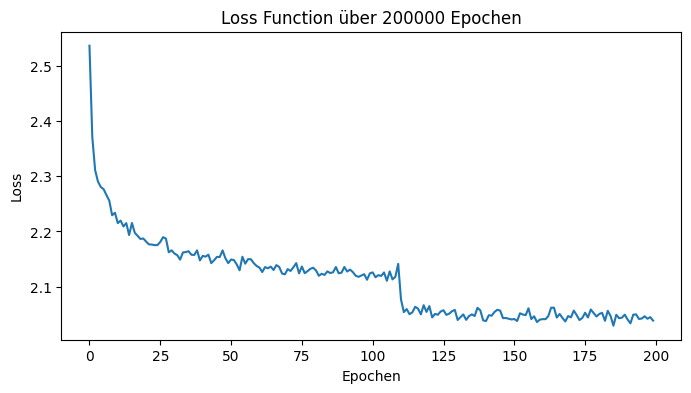

train Loss: 2.0153002738952637
dev Loss: 2.3264262676239014
test Loss: 2.3583691120147705


In [128]:
LR = 0.1
EPOCHEN = 200000
BATCH_SIZE = 32
lossi = []

for i in range(EPOCHEN):

    # Zufällige 32er Mini Batches jede Epoche -> "Stochastic Gradient Descent"
    ix = torch.randint(0, Xtr.shape[0], (BATCH_SIZE,))
    X, Y = Xtr[ix], Ytr[ix]

    # forward Pass
    logits = model(X)
    loss = F.cross_entropy(logits, Y)
    lossi.append(loss.item())

    if i % 10000 == 0:
        print("Epoche:", i, "LR", LR ,"Loss:", loss.item())

    # backward Pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update Parameters
    if i > 110000:
        LR = 0.01
    for p in parameters:
        p.data += -LR * p.grad

# Loss Function plotten:
# Avg über den Loss machen, damit plot nicer
lossi = torch.tensor(lossi).view(-1, 1000).mean(1)
plt.figure(figsize=(8, 4))
plt.plot(lossi)
plt.title(f"Loss Function über {EPOCHEN} Epochen")
plt.xlabel("Epochen")
plt.ylabel("Loss")
plt.show();

# Für BatchNorm Training deaktiveren, wegen Mean und Variance
for layer in model.layers:
    layer.training = False

#Letzter Forward Pass durch alle Daten, für Loss test
@torch.no_grad() # Kein Gradienten-Tracking, für Performance
def split_loss(split):
    x,y = {
        "train": (Xtr, Ytr),
        "dev": (Xdev, Ydev),
        "test": (Xte, Yte)
    }[split]

    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(f"{split} Loss:", loss.item())

split_loss("train")
split_loss("dev")
split_loss("test")

In [130]:
for _ in range(10):
    out = []
    context = [0] * block_size
    while True:
        logits = model(torch.tensor([context]))     
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(idx2char[i] for i in out))

emmyland.
magan.
geneah.
ems.
raangelekeh.
alby.
treia.
manu.
cameya.
shinra.


Man kann an den Unterschieden zwischen dem Trainings-, Validierungs- und Testdatensatz sehen, dass das Modell nicht überangepasst ist, weil die Genauigkeit auf dem Validierungsdatensatz nicht viel schlechter ist als auf dem Trainingsdatensatz.

Nun können wir aber das Modell mit der Embedding-Schicht nicht wirklich sinnvoll verbreitern und sind bereits bei Trigrammen. Man könnte das NN nun tiefer und breiter machen, aber es würde dadurch auch langsamer werden.

Daheer implementieren wir nun die Idee eines DeepMind Papers das "WaveNet" heißt (2016). 

https://arxiv.org/abs/1609.03499

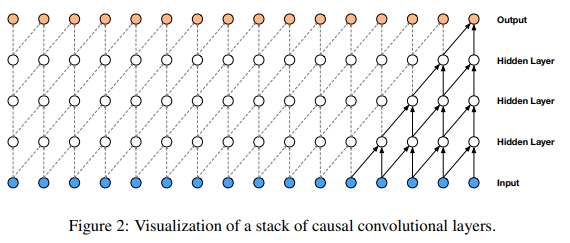

Der Name klingt komplex, die Idee ist aber einfach. Wir werden in der ersten Schicht mehrere Bigramme einführen und in der nächsten von zwei Bigrammen in eine Aktiverung führen und in der nächsten wiederum in von zwei Zusammenführungen zweier Bigramme.

In der Art und Weiße, verlieren wir weniger Informationen, da wir nicht wie hier in der ersten Schichten von einem Trigramm direkt alles über eine Embedding-Schicht in einen Layer crunshen.

WaveNet war die Kombination von drei Ideen:

1. Die Idee von "Dilated Causal Convolutions" (Dilated Convolutions) die in der Lage sind, die Informationen von weit entfernten Werten zu erfassen, ohne dass die Anzahl der Parameter steigt. (CNN)
2. Die Idee von "Gated Activation Units" (Gated Activation Units) die in der Lage sind, die Informationen zu filtern, die durch die Dilated Convolutions erfasst werden. (LSTM)
3. Die Idee von "Residual and Skip Connections" (Residual and Skip Connections) die in der Lage sind, die Informationen zu filtern, die durch die Dilated Convolutions erfasst werden.

Also im Grunde die Grundideen von CNNs, Residual Conntections und LSTM in einem Modell. 

In [147]:
import math
avg = 0
maxi = 0
mini = 50
std = 0
for word in words:
    length = len(word)
    avg += length
    std += (length - avg / len(words)) ** 2
    if length > maxi:
        maxi = length
    if length < mini:
        mini = length
avg = avg / len(words)
std = math.sqrt(std / len(words))

print("Avg: ", avg)
print("Max: ", maxi)
print("Min: ", mini)
print("Std: ", std)

Avg:  6.122217712983486
Max:  15
Min:  2
Std:  3.8331604887665547


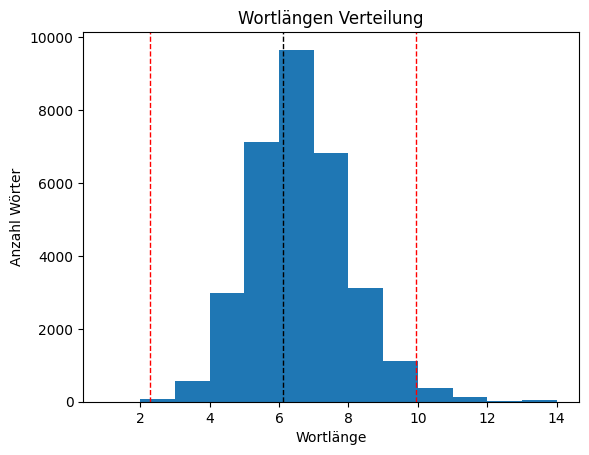

In [156]:
# Wortlängen als Verteilung Plotten und Mean und Std einzeichnen
plt.hist([len(w) for w in words], bins=range(1, 15))
plt.axvline(avg, color='k', linestyle='dashed', linewidth=1)
plt.axvline(avg - std, color='r', linestyle='dashed', linewidth=1)
plt.axvline(avg + std, color='r', linestyle='dashed', linewidth=1)
plt.title("Wortlängen Verteilung")
plt.xlabel("Wortlänge")
plt.ylabel("Anzahl Wörter")
plt.show();

Da wir eine avg Zeichenlänge von 6 haben und eine std. von 3.83 haben, verwenden wir nun erstmal als ``block_size`` nicht mehr $3$ sondern erstmal $8$:

In [5]:
block_size = 8

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = char2idx[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

random.seed(42)
shuffled_words = words.copy()
random.shuffle(shuffled_words)
n1 = int(0.8 * len(shuffled_words))
n2 = int(0.9 * len(shuffled_words))

Xtr, Ytr = build_dataset(words[:n1]) # 80% training
print("Train Length: ", len(Xtr))
Xdev, Ydev = build_dataset(words[n1:n2]) # 10% development
print("Dev   Length: ", len(Xdev))
Xte, Yte = build_dataset(words[n2:]) # 10% test
print("Test  Length: ", len(Xte))

Train Length:  182778
Dev   Length:  22633
Test  Length:  22735


In [6]:
for x, y in zip(Xtr[:17], Ytr[:17]):
    print("".join(idx2char[i.item()] for i in x), "-->", idx2char[y.item()])

........ --> e
.......e --> m
......em --> m
.....emm --> a
....emma --> .
........ --> o
.......o --> l
......ol --> i
.....oli --> v
....oliv --> i
...olivi --> a
..olivia --> .
........ --> a
.......a --> v
......av --> a
.....ava --> .
........ --> i


In [13]:
n_embd = 10
n_hidden = 200

model = Sequential([
    Embedding(vocab_size, n_embd),
    Flatten(),
    Linear(block_size * n_embd, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, vocab_size)
])

with torch.no_grad():
  model.layers[-1].weight *= 0.1 # letzten Layer weniger Confident machen, quasi Kaiming init, damit wir am Anfang nicht direkt einen hohen Loss haben

parameters = model.parameters()
print(sum(p.numel() for p in parameters))
for p in parameters:
  p.requires_grad = True

22097


Epoche: 0 LR 0.1 Loss: 3.3024210929870605
Epoche: 10000 LR 0.1 Loss: 2.4469516277313232
Epoche: 20000 LR 0.1 Loss: 2.229982614517212
Epoche: 30000 LR 0.1 Loss: 2.215482473373413
Epoche: 40000 LR 0.1 Loss: 1.7909051179885864
Epoche: 50000 LR 0.1 Loss: 2.259526014328003
Epoche: 60000 LR 0.1 Loss: 1.6549290418624878
Epoche: 70000 LR 0.1 Loss: 2.30920672416687
Epoche: 80000 LR 0.1 Loss: 1.8834806680679321
Epoche: 90000 LR 0.1 Loss: 1.7982577085494995
Epoche: 100000 LR 0.1 Loss: 2.44964599609375
Epoche: 110000 LR 0.1 Loss: 2.130293369293213
Epoche: 120000 LR 0.1 Loss: 1.7688913345336914
Epoche: 130000 LR 0.1 Loss: 1.7924333810806274
Epoche: 140000 LR 0.1 Loss: 1.819265604019165
Epoche: 150000 LR 0.1 Loss: 1.8638752698898315
Epoche: 160000 LR 0.01 Loss: 1.9258239269256592
Epoche: 170000 LR 0.01 Loss: 1.9535545110702515
Epoche: 180000 LR 0.01 Loss: 1.986833095550537
Epoche: 190000 LR 0.01 Loss: 1.7523651123046875


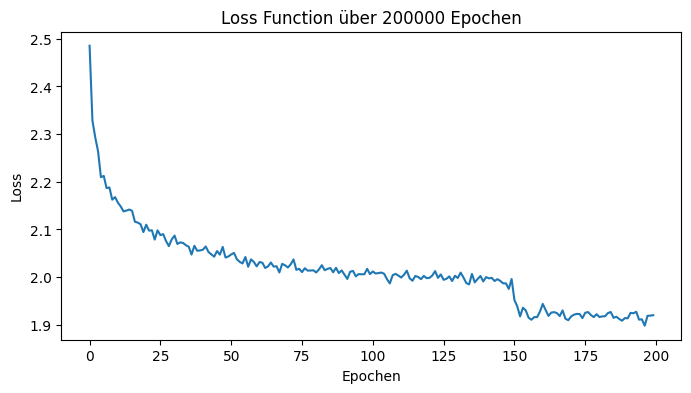

train Loss: 1.8739467859268188
dev Loss: 2.2527177333831787
test Loss: 2.2831802368164062


In [15]:
LR = 0.1
EPOCHEN = 200000
BATCH_SIZE = 32
lossi = []

for i in range(EPOCHEN):

    # Zufällige 32er Mini Batches jede Epoche -> "Stochastic Gradient Descent"
    ix = torch.randint(0, Xtr.shape[0], (BATCH_SIZE,))
    X, Y = Xtr[ix], Ytr[ix]

    # forward Pass
    logits = model(X)
    loss = F.cross_entropy(logits, Y)
    lossi.append(loss.item())

    if i % 10000 == 0:
        print("Epoche:", i, "LR", LR ,"Loss:", loss.item())

    # backward Pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update Parameters
    if i > 150000:
        LR = 0.01
    for p in parameters:
        p.data += -LR * p.grad

# Loss Function plotten:
# Avg über den Loss machen, damit plot nicer
lossi = torch.tensor(lossi).view(-1, 1000).mean(1)
plt.figure(figsize=(8, 4))
plt.plot(lossi)
plt.title(f"Loss Function über {EPOCHEN} Epochen")
plt.xlabel("Epochen")
plt.ylabel("Loss")
plt.show();

# Für BatchNorm Training deaktiveren, wegen Mean und Variance
for layer in model.layers:
    layer.training = False

#Letzter Forward Pass durch alle Daten, für Loss test
@torch.no_grad() # Kein Gradienten-Tracking, für Performance
def split_loss(split):
    x,y = {
        "train": (Xtr, Ytr),
        "dev": (Xdev, Ydev),
        "test": (Xte, Yte)
    }[split]

    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(f"{split} Loss:", loss.item())

split_loss("train")
split_loss("dev")
split_loss("test")

In [190]:
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        logits = model(torch.tensor([context]))     
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(idx2char[i] for i in out))

roralee.
laiten.
zamir.
tilli.
rya.
larhyue.
suvmara.
juleie.
dagesty.
pannah.
nayuin.
zohir.
sando.
noanna.
aubrian.
pren.
ociah.
oniya.
orci.
augi.


Der Loss ist niedriger und die Namen sind qualitativ geworden. Allein mit einer breiten Context-Length.

In [194]:
# wir hatten ja nun 8 Zeichen in einem Block:
# 1  2  3  4  5  6  7  8
# nun wollen wir diese in Paare aufteilen:
# (1 2) (3 4) (5 6) (7 8)

# schauen wir uns unseren bisherigen Embedding Layer an:
model.layers[0].out.shape # hier 32er Batches

torch.Size([32, 8, 10])

In [196]:
model.layers[0].out[0]

tensor([[ 0.6129, -0.1234,  1.1036, -0.8266, -0.0056,  1.6035, -0.8209, -0.2244,
          0.9184,  0.2349],
        [ 0.6129, -0.1234,  1.1036, -0.8266, -0.0056,  1.6035, -0.8209, -0.2244,
          0.9184,  0.2349],
        [ 0.6129, -0.1234,  1.1036, -0.8266, -0.0056,  1.6035, -0.8209, -0.2244,
          0.9184,  0.2349],
        [ 0.6129, -0.1234,  1.1036, -0.8266, -0.0056,  1.6035, -0.8209, -0.2244,
          0.9184,  0.2349],
        [ 0.6129, -0.1234,  1.1036, -0.8266, -0.0056,  1.6035, -0.8209, -0.2244,
          0.9184,  0.2349],
        [ 0.5210,  0.2570, -0.7663, -0.2689, -1.7101,  0.6672, -0.4407, -0.5273,
          1.3915, -1.1470],
        [-0.7362, -0.4240, -0.9327, -0.3483, -1.1920,  1.2766, -1.0236, -0.3088,
         -0.9485,  2.4971],
        [ 1.3581, -0.1454, -0.2748,  1.7314,  0.7360,  1.9818, -0.0391, -1.9408,
         -0.3680,  0.3522]], grad_fn=<SelectBackward0>)

In [199]:
# beim flattening hängen wir die 10er einfach alle aneinander an:
model.layers[1].out.shape, model.layers[1].out[0]

(torch.Size([32, 80]),
 tensor([ 0.6129, -0.1234,  1.1036, -0.8266, -0.0056,  1.6035, -0.8209, -0.2244,
          0.9184,  0.2349,  0.6129, -0.1234,  1.1036, -0.8266, -0.0056,  1.6035,
         -0.8209, -0.2244,  0.9184,  0.2349,  0.6129, -0.1234,  1.1036, -0.8266,
         -0.0056,  1.6035, -0.8209, -0.2244,  0.9184,  0.2349,  0.6129, -0.1234,
          1.1036, -0.8266, -0.0056,  1.6035, -0.8209, -0.2244,  0.9184,  0.2349,
          0.6129, -0.1234,  1.1036, -0.8266, -0.0056,  1.6035, -0.8209, -0.2244,
          0.9184,  0.2349,  0.5210,  0.2570, -0.7663, -0.2689, -1.7101,  0.6672,
         -0.4407, -0.5273,  1.3915, -1.1470, -0.7362, -0.4240, -0.9327, -0.3483,
         -1.1920,  1.2766, -1.0236, -0.3088, -0.9485,  2.4971,  1.3581, -0.1454,
         -0.2748,  1.7314,  0.7360,  1.9818, -0.0391, -1.9408, -0.3680,  0.3522],
        grad_fn=<SelectBackward0>))

Nun wir könnte man jetzt bei den 8 Zeichen immer den ersten und dann den zweiten in ein paar bringen. Man könnte mit gerade und ungerade stellen arbeiten:

In [204]:
print("ungerade:", list(range(8))[1::2])
print("gerade  :", list(range(8))[::2])

ungerade: [1, 3, 5, 7]
gerade  : [0, 2, 4, 6]


In [207]:
# Vorher hatten wir ja (32, 8, 10), nun wollen wir (32, 4, 20), 20 weil 10 + 10, da wir ja 2 Embeddings aneinander hängen
model.layers[1].out.view(-1, 4, 20).shape, model.layers[1].out.view(-1, 4, 20) # -1 für vorherige Eingangsdimension, war hier ja die batch_size

(torch.Size([32, 4, 20]),
 tensor([[[ 0.6129, -0.1234,  1.1036,  ..., -0.2244,  0.9184,  0.2349],
          [ 0.6129, -0.1234,  1.1036,  ..., -0.2244,  0.9184,  0.2349],
          [ 0.6129, -0.1234,  1.1036,  ..., -0.5273,  1.3915, -1.1470],
          [-0.7362, -0.4240, -0.9327,  ..., -1.9408, -0.3680,  0.3522]],
 
         [[ 0.6129, -0.1234,  1.1036,  ..., -0.2244,  0.9184,  0.2349],
          [ 0.6129, -0.1234,  1.1036,  ..., -0.2244,  0.9184,  0.2349],
          [ 0.6129, -0.1234,  1.1036,  ..., -0.8124,  1.2987,  2.6952],
          [ 0.5210,  0.2570, -0.7663,  ..., -1.9408, -0.3680,  0.3522]],
 
         [[ 0.6129, -0.1234,  1.1036,  ..., -0.2244,  0.9184,  0.2349],
          [ 0.6129, -0.1234,  1.1036,  ..., -0.2244,  0.9184,  0.2349],
          [ 0.0042,  0.3445,  0.5842,  ..., -0.3088, -0.9485,  2.4971],
          [ 0.5210,  0.2570, -0.7663,  ..., -0.4718, -1.1109,  0.3407]],
 
         ...,
 
         [[ 0.6129, -0.1234,  1.1036,  ..., -0.2244,  0.9184,  0.2349],
          [ 0

Das tatsächlich das gleiche, als wenn hier mit Geraden und Ungeraden arbeiten würden. Wir müssen nun also unsere Flatten Klasse anpassen:

In [73]:
# -----------------------------------------------------------------------------------------------
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init, basierend auf der Eingangsdimension "fan_in"
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Embedding:

    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self):
        return [self.weight]

# -----------------------------------------------------------------------------------------------
class FlattenConsecutivePairs:

    def __init__(self, n):
        self.n = n

    def __call__(self, x):
        B, T, C = x.shape # 32, 8, 10
        x = x.view(B, T//self.n, C * self.n) # 32, 4, 20            // ist eine integer division
        # Falls wir das so wie vorher haben wollen, was ja (32, 80) war, dann:
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out
    
    def parameters(self):
        return []

# -----------------------------------------------------------------------------------------------
class Sequential:
  
  def __init__(self, layers):
    self.layers = layers
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()] # flatten list of parameters
  
# -----------------------------------------------------------------------------------------------

In [74]:
block_size = 8
n_embd = 10
n_hidden = 200

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutivePairs(8),
    Linear(block_size * n_embd, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, vocab_size)
])

with torch.no_grad():
  model.layers[-1].weight *= 0.1 # letzten Layer weniger Confident machen, quasi Kaiming init, damit wir am Anfang nicht direkt einen hohen Loss haben

parameters = model.parameters()
print(sum(p.numel() for p in parameters))
for p in parameters:
  p.requires_grad = True

22097


In [77]:
# Kurzer Anlauf damit die "outs" initialisiert werden
ix = torch.randint(0, Xtr.shape[0], (32,)) # 32er Batches
X, Y = Xtr[ix], Ytr[ix]
logits = model(X)

In [78]:
for layer in model.layers:
        print(tuple(layer.out.shape), layer.__class__.__name__)

(32, 8, 10) Embedding
(32, 80) FlattenConsecutivePairs
(32, 200) Linear
(32, 200) BatchNorm1d
(32, 200) Tanh
(32, 27) Linear


Looks alright. Nun bauen wir das Wavenet, mit den zweier Pärchen in jedem Layer, nun aber mit 4er Batches:

In [79]:
# Hier wird block_size nun ersetzt durch das Verfahren in WaveNet mit dilated convolutions

n_embd = 10
n_hidden = 200

model = Sequential([
    Embedding(vocab_size, n_embd),
    # 1. Layer:
    FlattenConsecutivePairs(2),
    Linear(2 * n_embd, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    # 2. Layer:
    FlattenConsecutivePairs(2),
    Linear(2 * n_hidden, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    # 3. Layer:
    FlattenConsecutivePairs(2),
    Linear(2 * n_hidden, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    # Output Layer:
    Linear(n_hidden, vocab_size)
])

with torch.no_grad():
  model.layers[-1].weight *= 0.1 # letzten Layer weniger Confident machen, quasi Kaiming init, damit wir am Anfang nicht direkt einen hohen Loss haben

parameters = model.parameters()
print(sum(p.numel() for p in parameters))
for p in parameters:
  p.requires_grad = True

170897


In [81]:
# Kurzer Anlauf damit die "outs" initialisiert werden
ix = torch.randint(0, Xtr.shape[0], (32,)) # 32er Batches
X, Y = Xtr[ix], Ytr[ix]
logits = model(X)

for layer in model.layers:
        print(tuple(layer.out.shape), layer.__class__.__name__)

(32, 8, 10) Embedding
(32, 4, 20) FlattenConsecutivePairs
(32, 4, 200) Linear
(32, 4, 200) BatchNorm1d
(32, 4, 200) Tanh
(32, 2, 400) FlattenConsecutivePairs
(32, 2, 200) Linear
(32, 2, 200) BatchNorm1d
(32, 2, 200) Tanh
(32, 400) FlattenConsecutivePairs
(32, 200) Linear
(32, 200) BatchNorm1d
(32, 200) Tanh
(32, 27) Linear


Die FlattenConsecutivePairs-Operation nimmt aufeinanderfolgende Paare von Buchstaben (repräsentiert durch ihre Embedding-Vektoren) und "flacht" sie zu einem einzigen Vektor.

Angenommen, wir haben vier Wörter: ["a", "n", "n", "a"], die durch ihre Embedding-Vektoren repräsentiert werden. Nach der FlattenConsecutivePairs-Operation hätten wir zwei Paare: ["a", "n"] und ["n", "a"].

Die FlattenConsecutivePairs-Operation wird verwendet, um die Beziehungen zwischen aufeinanderfolgenden Buchstaben in der Eingabesequenz zu erfassen. Durch das Zusammenfassen von aufeinanderfolgenden Buchstaben in Paaren und das "Flachmachen" dieser Paare zu einem einzigen Vektor kann das Modell lernen, wie die Bedeutung eines Buchstabens durch den Vorhergehenden beeinflusst wird.

Die Wiederholung dieser Operation in aufeinanderfolgenden Schichten ermöglicht es dem Modell, Beziehungen über größere Distanzen in der Eingabesequenz zu erfassen. In der ersten Schicht erfasst das Modell die Beziehungen zwischen aufeinanderfolgenden Buchstaben. In der zweiten Schicht erfasst das Modell die Beziehungen zwischen aufeinanderfolgenden Paaren von Buchstaben, was einer größeren Distanz in der ursprünglichen Eingabesequenz entspricht.

Diese Art von Modellarchitektur ist besonders nützlich für Aufgaben, die eine Verarbeitung von sequenziellen Daten erfordern, wie z.B. Textverarbeitung, Spracherkennung oder Zeitreihenanalyse. Durch das Erfassen von Beziehungen über verschiedene Distanzen hinweg kann das Modell komplexere Muster in den Daten lernen.

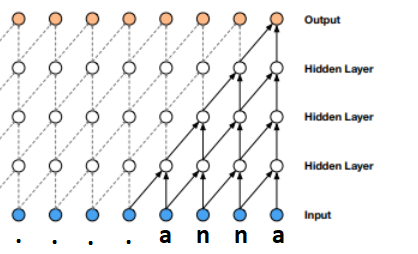

Block_Size war ja unsere "Context Length" quasi. Also 8 Eingaben und dann die FlattenConsecutivePairs. Da 170k an Parameter etwas viel ist, verändern wir nun die Hidden Size auf 68:

In [88]:
n_embd = 10
n_hidden = 68

model = Sequential([
    Embedding(vocab_size, n_embd),
    # 1. Layer:
    FlattenConsecutivePairs(2),
    Linear(2 * n_embd, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    # 2. Layer:
    FlattenConsecutivePairs(2),
    Linear(2 * n_hidden, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    # 3. Layer:
    FlattenConsecutivePairs(2),
    Linear(2 * n_hidden, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    # Output Layer:
    Linear(n_hidden, vocab_size)
])

with torch.no_grad():
  model.layers[-1].weight *= 0.1 # letzten Layer weniger Confident machen, quasi Kaiming init, damit wir am Anfang nicht direkt einen hohen Loss haben

parameters = model.parameters()
print(sum(p.numel() for p in parameters))
for p in parameters:
  p.requires_grad = True

22397


Epoche: 0 LR 0.1 Loss: 3.2885708808898926
Epoche: 10000 LR 0.1 Loss: 1.9208440780639648
Epoche: 20000 LR 0.1 Loss: 1.9776171445846558
Epoche: 30000 LR 0.1 Loss: 1.927286148071289
Epoche: 40000 LR 0.1 Loss: 2.330660820007324
Epoche: 50000 LR 0.1 Loss: 1.6603609323501587
Epoche: 60000 LR 0.1 Loss: 1.8289811611175537
Epoche: 70000 LR 0.1 Loss: 2.2912120819091797
Epoche: 80000 LR 0.1 Loss: 2.038496255874634
Epoche: 90000 LR 0.1 Loss: 2.1784660816192627
Epoche: 100000 LR 0.1 Loss: 2.2360689640045166
Epoche: 110000 LR 0.1 Loss: 1.4092411994934082
Epoche: 120000 LR 0.1 Loss: 2.012495517730713
Epoche: 130000 LR 0.1 Loss: 1.8358097076416016
Epoche: 140000 LR 0.1 Loss: 1.86271071434021
Epoche: 150000 LR 0.1 Loss: 2.4695675373077393
Epoche: 160000 LR 0.01 Loss: 2.0008606910705566
Epoche: 170000 LR 0.01 Loss: 1.7492188215255737
Epoche: 180000 LR 0.01 Loss: 1.9605497121810913
Epoche: 190000 LR 0.01 Loss: 1.7535854578018188


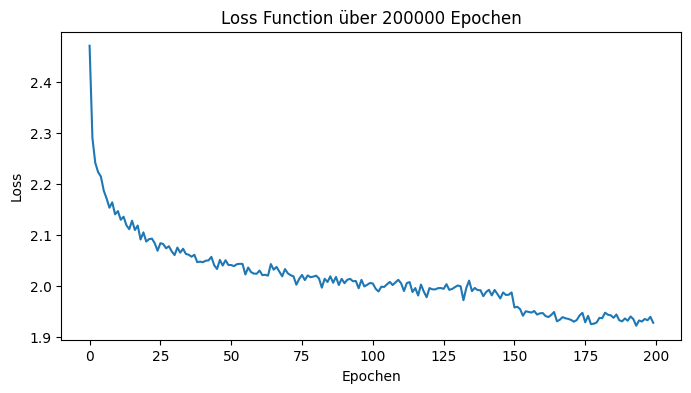

train Loss: 1.8922430276870728
dev Loss: 2.239699602127075
test Loss: 2.2765913009643555


In [85]:
LR = 0.1
EPOCHEN = 200000
BATCH_SIZE = 32
lossi = []

for i in range(EPOCHEN):

    # Zufällige 32er Mini Batches jede Epoche -> "Stochastic Gradient Descent"
    ix = torch.randint(0, Xtr.shape[0], (BATCH_SIZE,))
    X, Y = Xtr[ix], Ytr[ix]

    # forward Pass
    logits = model(X)
    loss = F.cross_entropy(logits, Y)
    lossi.append(loss.item())

    if i % 10000 == 0:
        print("Epoche:", i, "LR", LR ,"Loss:", loss.item())

    # backward Pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update Parameters
    if i > 150000:
        LR = 0.01
    for p in parameters:
        p.data += -LR * p.grad

# Loss Function plotten:
# Avg über den Loss machen, damit plot nicer
lossi = torch.tensor(lossi).view(-1, 1000).mean(1)
plt.figure(figsize=(8, 4))
plt.plot(lossi)
plt.title(f"Loss Function über {EPOCHEN} Epochen")
plt.xlabel("Epochen")
plt.ylabel("Loss")
plt.show();

# Für BatchNorm Training deaktiveren, wegen Mean und Variance
for layer in model.layers:
    layer.training = False

#Letzter Forward Pass durch alle Daten, für Loss test
@torch.no_grad() # Kein Gradienten-Tracking, für Performance
def split_loss(split):
    x,y = {
        "train": (Xtr, Ytr),
        "dev": (Xdev, Ydev),
        "test": (Xte, Yte)
    }[split]

    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(f"{split} Loss:", loss.item())

split_loss("train")
split_loss("dev")
split_loss("test")

Wir haben keine Großen Veränderung weil noch etwas an dem BatchNorm Layer passieren muss, der macht gerade nämlich means und vars über die 2. Dimension und nicht einfach über alle und fasst zusammen:

In [86]:
model.layers[3].running_mean.shape

torch.Size([1, 4, 68])

Das brauchen wir eigentlich als (1, 1, 68):

In [87]:
# -----------------------------------------------------------------------------------------------
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init, basierend auf der Eingangsdimension "fan_in"
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
         dim = 0
      elif x.ndim == 3:
         dim = (0, 1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Embedding:

    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self):
        return [self.weight]

# -----------------------------------------------------------------------------------------------
class FlattenConsecutivePairs:

    def __init__(self, n):
        self.n = n

    def __call__(self, x):
        B, T, C = x.shape # 32, 8, 10
        x = x.view(B, T//self.n, C * self.n) # 32, 4, 20            // ist eine integer division
        # Falls wir das so wie vorher haben wollen, was ja (32, 80) war, dann:
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out
    
    def parameters(self):
        return []

# -----------------------------------------------------------------------------------------------
class Sequential:
  
  def __init__(self, layers):
    self.layers = layers
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()] # flatten list of parameters
  
# -----------------------------------------------------------------------------------------------

Epoche: 0 LR 0.1 Loss: 3.2911694049835205
Epoche: 10000 LR 0.1 Loss: 1.702376365661621
Epoche: 20000 LR 0.1 Loss: 2.3181424140930176
Epoche: 30000 LR 0.1 Loss: 2.303253650665283
Epoche: 40000 LR 0.1 Loss: 2.2017931938171387
Epoche: 50000 LR 0.1 Loss: 1.8291126489639282
Epoche: 60000 LR 0.1 Loss: 1.6468279361724854
Epoche: 70000 LR 0.1 Loss: 1.933872938156128
Epoche: 80000 LR 0.1 Loss: 1.9996854066848755
Epoche: 90000 LR 0.1 Loss: 2.1027369499206543
Epoche: 100000 LR 0.1 Loss: 2.158881902694702
Epoche: 110000 LR 0.1 Loss: 1.6793651580810547
Epoche: 120000 LR 0.1 Loss: 2.140166759490967
Epoche: 130000 LR 0.1 Loss: 1.9900075197219849
Epoche: 140000 LR 0.1 Loss: 1.7680048942565918
Epoche: 150000 LR 0.1 Loss: 2.213973045349121
Epoche: 160000 LR 0.01 Loss: 2.1425833702087402
Epoche: 170000 LR 0.01 Loss: 2.0960917472839355
Epoche: 180000 LR 0.01 Loss: 2.081639528274536
Epoche: 190000 LR 0.01 Loss: 1.4945083856582642


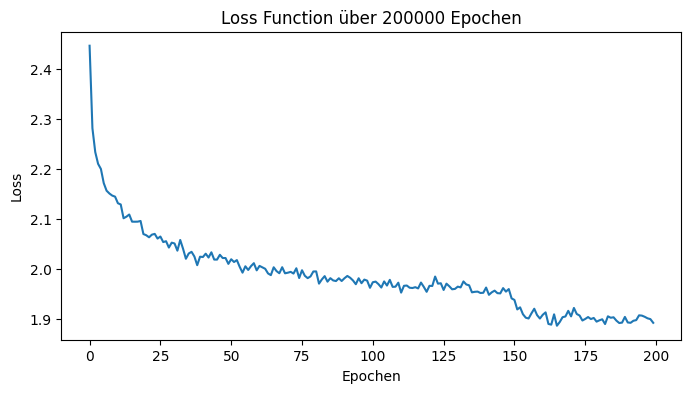

train Loss: 1.8657773733139038
dev Loss: 2.251288652420044
test Loss: 2.2856931686401367


In [89]:
LR = 0.1
EPOCHEN = 200000
BATCH_SIZE = 32
lossi = []

for i in range(EPOCHEN):

    # Zufällige 32er Mini Batches jede Epoche -> "Stochastic Gradient Descent"
    ix = torch.randint(0, Xtr.shape[0], (BATCH_SIZE,))
    X, Y = Xtr[ix], Ytr[ix]

    # forward Pass
    logits = model(X)
    loss = F.cross_entropy(logits, Y)
    lossi.append(loss.item())

    if i % 10000 == 0:
        print("Epoche:", i, "LR", LR ,"Loss:", loss.item())

    # backward Pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update Parameters
    if i > 150000:
        LR = 0.01
    for p in parameters:
        p.data += -LR * p.grad

# Loss Function plotten:
# Avg über den Loss machen, damit plot nicer
lossi = torch.tensor(lossi).view(-1, 1000).mean(1)
plt.figure(figsize=(8, 4))
plt.plot(lossi)
plt.title(f"Loss Function über {EPOCHEN} Epochen")
plt.xlabel("Epochen")
plt.ylabel("Loss")
plt.show();

# Für BatchNorm Training deaktiveren, wegen Mean und Variance
for layer in model.layers:
    layer.training = False

#Letzter Forward Pass durch alle Daten, für Loss test
@torch.no_grad() # Kein Gradienten-Tracking, für Performance
def split_loss(split):
    x,y = {
        "train": (Xtr, Ytr),
        "dev": (Xdev, Ydev),
        "test": (Xte, Yte)
    }[split]

    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(f"{split} Loss:", loss.item())

split_loss("train")
split_loss("dev")
split_loss("test")

In [90]:
model.layers[3].running_mean.shape

torch.Size([1, 1, 68])

Nun haben wir es gefixed, aber die Performance ist immer noch nicht viel besser und das liegt daran, dass wir von WaveNet immer noch nicht die Residual Connections und das LSTM Prinzip eingebaut haben. Hat Andrej leider nicht mehr gemacht.

In [92]:
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        logits = model(torch.tensor([context]))     
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(idx2char[i] for i in out))

nylora.
duntlynn.
jezediah.
saben.
yuxi.
no.
aadiyah.
tricte.
christ.
bracala.
nayva.
kyanna.
michri.
audriqanna.
mattisle.
amorahaia.
anaysyn.
amilya.
hasha.
jaece.


Die Namen sehen aber schonmal etwas besser aus, glaub ich